In [5]:

##### The script is to classify the bacterial motion by assigning the trajectory points two states: run and tumble;
##### then compute some key metrics for Figure 2 and Supplementary Fig 2 & 3.
import os
import glob,csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable


# In[ ]:


#define a function to calculate the velocity
def calculate_velocity(x_positions, y_positions, time_positions,interval:int, fps):
    #Initialize the velocity arrays with NaNs
    vx = np.full(len(x_positions),np.nan)
    vy = np.full(len(y_positions),np.nan)
    
    # Calculate the differences in positions and time
    
    valid_indices = np.arange(interval, len(x_positions))
    dx = np.array(x_positions)[valid_indices] - np.array(x_positions)[:-interval]
    dy = np.array(y_positions)[valid_indices] - np.array(y_positions)[:-interval]
    dt = (np.array(time_positions)[valid_indices] - np.array(time_positions)[:-interval]) / fps 
    
    # Calculate velocity components vx and vy
    vx[valid_indices] = dx / dt
    vy[valid_indices] = dy / dt
    
    # Return velocity vectors as a list of arrays
    velocity_vectors = [np.array([vx[i], vy[i]]) for i in range(len(vx))]
    
    return velocity_vectors


# In[ ]:


#define a function to calculate the angle
def dtheta(list_of_vels):
    dtheta = [np.nan]
    for i in range(1, len(list_of_vels)-1):
        vt = list_of_vels[i]
        v_dt = list_of_vels[i+1]
        v_dot = np.dot(vt,v_dt)
        v_cross = np.cross(vt,v_dt)
        theta = abs(np.arctan2(v_cross,v_dot))
        #deg = np.rad2deg(abs(np.arctan2(v_cross,v_dot)))
        dtheta.append(theta)
    dtheta.append(np.nan)
    return dtheta 


# In[ ]:


#define a function to classify run and tumble and compute the key metrics: run time, tumble time, run and tumble proportion
def macrostates(speed_thresh, angle_thresh, df: pd.DataFrame):
    ## The lists to record the positions
    runs = []
    tumbles = []
    uncluster = []

    ## The lists to record corresponding speeds and angles
    run_s = []
    run_a = []
    tumble_s = []
    tumble_a = []

    ## The lists to record the time stamps 
    run_t = []
    tumble_t = []

    ## The lists to record the run and tumble lengths
    run_ls = []
    run_dts = []
    tumble_dts = []

    run_start_point = None
    tumble_start_point = None

    for idx, row in df.iterrows():
        x = row['rescaled_pos'][0]
        y = row['rescaled_pos'][1]
        speed = row['speed']
        angle = row['angle']

        if pd.notna(speed) and pd.notna(angle) and speed >= speed_thresh and angle <= angle_thresh:
            runs.append(row['rescaled_pos'])
            run_t.append(row['rescaled_time'])
            run_s.append(row['speed'])
            run_a.append(row['angle'])

            if run_start_point is None:
                run_start_point = (x, y)
                run_start_time = row['rescaled_time']

            run_end_point = (x, y)
            run_end_time = row['rescaled_time']

            if tumble_start_point is not None:
                tumble_duration = tumble_end_time - tumble_start_time
                if tumble_duration != 0:
                    tumble_dts.append(tumble_duration)
                tumble_start_point = None  # Reset tumble_start_point after ending the tumble

        else:
            if pd.notna(speed) and pd.notna(angle) and speed < speed_thresh and angle >= 0:
                tumbles.append(row['rescaled_pos'])
                tumble_t.append(row['rescaled_time'])
                tumble_s.append(row['speed'])
                tumble_a.append(row['angle'])

                if tumble_start_point is None:
                    tumble_start_point = (x, y)
                    tumble_start_time = row['rescaled_time']

                tumble_end_point = (x, y)
                tumble_end_time = row['rescaled_time']

                if run_start_point is not None:
                    run_distance = np.sqrt((run_end_point[0] - run_start_point[0])**2 + (run_end_point[1] - run_start_point[1])**2)
                    run_duration = run_end_time - run_start_time
                    if run_distance != 0:
                        run_ls.append(run_distance)
                    if run_duration > 0:
                        run_dts.append(run_duration)
                    run_start_point = None  # Reset run_start_point after ending the run

            if pd.notna(speed) and pd.notna(angle) and speed > speed_thresh and angle > angle_thresh:
                uncluster.append(row['rescaled_pos'])

    # If a run was ongoing at the end of the loop, add the final segment
    if run_start_point is not None:
        run_distance = np.sqrt((run_end_point[0] - run_start_point[0])**2 + (run_end_point[1] - run_start_point[1])**2)
        run_duration = run_end_time - run_start_time
        run_ls.append(run_distance)
        if run_duration > 0:
            run_dts.append(run_duration)

    # If a tumble was ongoing at the end of the loop, add the final segment
    if tumble_start_point is not None:
        tumble_duration = tumble_end_time - tumble_start_time
        if tumble_duration > 0:
            tumble_dts.append(tumble_duration)

    return runs, tumbles, uncluster, run_t, tumble_t, run_s, tumble_s, run_a, tumble_a, run_dts, tumble_dts, run_ls


# In[ ]:


upperdir = '/'.join(os.getcwd().split('/')[:-1]) #define upper directory
lowerdir = '/sorted_tracks/' #define lower directory where all the data is located
files = glob.glob(upperdir + lowerdir + '*.csv') #grab all the files in their pathways 
files = sorted(files) #sort the files based on the naming
len(files)



91

In [6]:


#Include the velocity and angle calculations 
datadic = {} #set up a data directory
dev = [] #number of device
pil= [] #number of confinement
dis = [] #number of disorders
rep = [] #number of repititions 
pixel_to_micron = 0.656 #pixel to micron (from Miles)
fps = 20 #frames per second
interval = [1,2]

for file in files:
    
    curr_data = pd.read_csv(file)
    data = curr_data[['TRACK_ID','POSITION_X','POSITION_Y','POSITION_T']]
    grouped_df = data.groupby('TRACK_ID')
    # Filter out data with less spots
    minimum_spots = 160  # Replace this with a desired "minimum_spots" value
    filtered_df = grouped_df.filter(lambda group: len(group) >= minimum_spots)
    # Reindex the track IDs starting from 1
    filtered_df.reset_index(drop=True, inplace=True) #reindex the column starting from 0
    df = filtered_df.groupby('TRACK_ID', group_keys=True, as_index=False).apply(lambda x: x) #group the dataframe by TRACK_ID
    df.reset_index(level=0, inplace=True) #move the first level to a separate column
    df.rename(columns={'level_0': 'ID'}, inplace=True) #rename new level  
    track_names = df['ID'].unique().tolist()
    #print(df)
    
    device = file.split('-')[-5] #retrieve the strains used in each microfluidic device 
    pillar = file.split('-')[-4] #retrieve the specific confinement 
    disorder = file.split('-')[-3] #retrieve the specific disorder degree
    #repetition = file.split('-')[-1][:4] #the first four letter
    if device not in datadic:
        dev.extend([device])
        datadic[device] = {} 
    if pillar not in datadic[device]:
        if pillar not in pil:
            pil.extend([pillar])
        datadic[device][pillar] = {}
    if disorder not in datadic[device][pillar]:
        if disorder not in dis:
            dis.extend([disorder])
        datadic[device][pillar][disorder] = {}
        datadic[device][pillar][disorder]['time'] = {}
        datadic[device][pillar][disorder]['rescaled_time'] = {} #Create a list to store all 'rescaled' time info
        datadic[device][pillar][disorder]['pos'] = {}
        datadic[device][pillar][disorder]['rescaled_pos'] = {} #Create a list to store all 'rescaled' x and y info
        #datadic[device][pillar][disorder]['MSD'] = [[]]
        datadic[device][pillar][disorder]['speed'] = {}
        datadic[device][pillar][disorder]['angle'] = {}

    for dt in interval:
        if dt not in datadic[device][pillar][disorder]['time']:
            datadic[device][pillar][disorder]['time'][dt] = []
        if dt not in datadic[device][pillar][disorder]['rescaled_time']:
            datadic[device][pillar][disorder]['rescaled_time'][dt] = []
        if dt not in datadic[device][pillar][disorder]['pos']:
            datadic[device][pillar][disorder]['pos'][dt] = []
        if dt not in datadic[device][pillar][disorder]['rescaled_pos']:
            datadic[device][pillar][disorder]['rescaled_pos'][dt] = []    
        if dt not in datadic[device][pillar][disorder]['speed']:
            datadic[device][pillar][disorder]['speed'][dt] = []
        if dt not in datadic[device][pillar][disorder]['angle']:
            datadic[device][pillar][disorder]['angle'][dt] = []
        
        for i in range(len(track_names)):
            time = np.array(df[df['ID']==track_names[i]]['POSITION_T'].tolist())
            time_start = time[0]
            datadic[device][pillar][disorder]['time'][dt].append(time)
            datadic[device][pillar][disorder]['rescaled_time'][dt].append([(time[i]-time_start)/fps for i in range(len(time))]) #rescale the time as well based on fps
            
            x_pos = np.array(df[df['ID']==track_names[i]]['POSITION_X'].tolist())
            y_pos = np.array(df[df['ID']==track_names[i]]['POSITION_Y'].tolist())
            x_pos_rescaled = x_pos*pixel_to_micron
            y_pos_rescaled = y_pos*pixel_to_micron
            x_start = x_pos[0]
            y_start = y_pos[0] 
            datadic[device][pillar][disorder]['pos'][dt].append([(x_pos[t]-x_start,y_pos[t]-y_start) for t in range(len(x_pos))])
            datadic[device][pillar][disorder]['rescaled_pos'][dt].append([(x_pos_rescaled[t], y_pos_rescaled[t]) for t in range(len(x_pos))])

            velocities = calculate_velocity(x_pos_rescaled, y_pos_rescaled, time, dt, fps)

            angles = dtheta(velocities)

            datadic[device][pillar][disorder]['angle'][dt].append(angles)

            speeds = [np.nan]*len(x_pos)

            for j in range(dt, len(x_pos)):
                speed = np.sqrt(pixel_to_micron*(x_pos[j]-x_pos[j-dt])**2+pixel_to_micron*(y_pos[j]-y_pos[j-dt])**2)/(dt/fps)

                speeds[j] = speed

            datadic[device][pillar][disorder]['speed'][dt].append(speeds)        


# In[ ]:


###collect the data for all angles and speeds and store it in a DataFrame
v_theta = []
for dt in interval:
    for dev in list(datadic):
        for pil in list(datadic[dev]):
            for dis in list(datadic[dev][pil]):
                v_theta.extend([(dt, dev, pil, dis, pos, speed, angle, time) for pos, speed, angle, time 
                in zip(datadic[dev][pil][dis]['rescaled_pos'][dt], datadic[dev][pil][dis]['speed'][dt], 
                       datadic[dev][pil][dis]['angle'][dt], datadic[dev][pil][dis]['rescaled_time'][dt])])

df = pd.DataFrame(v_theta, columns=['dt', 'strain', 'confinement', 'disorder', 'p', 's', 'a','t'])

pillar_mapping = {'pil0': 'Unc', 'pil1': 'C = 6 µm', 'pil2': 'C = 2.6 µm', 'pil3': 'C = 1.3 µm'}
disorder_mapping = {'dis0': 'no pillar', 'dis1': 'D = 0', 'dis2': 'D = 1', 
                    'dis3': 'D = 2', 'dis4':'D = 3'}

# Replace the category names in the DataFrame
df['confinement'] = df['confinement'].replace(pillar_mapping)
df['disorder'] = df['disorder'].replace(disorder_mapping) 

#Merge the two columns to one 'condition' column
df['condition'] = df['confinement'] + '; ' + df['disorder']
#df.drop(['confinement', 'disorder'], axis=1, inplace=True)
sub_dfs = {dt: group for dt, group in df.groupby('dt')}

#explode the lists in the columns of speed, angle and rescaled time
df_exploded = sub_dfs[1].explode(list('psat'))
df_exploded['p'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_exploded['s'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_exploded['a'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_exploded['t'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_exploded = df_exploded.rename(columns={'p':'rescaled_pos', 's':'speed', 'a':'angle', 't':'rescaled_time'})
# df_exploded['condition'] = df_exploded['condition'].astype('category')
df_exploded

,dt,strain,confinement,disorder,rescaled_pos,speed,angle,rescaled_time,condition
0,1,dev1,Unc,no pillar,"(282.736, 0.0)",NaN,NaN,0.0,Unc; no pillar
0,1,dev1,Unc,no pillar,"(282.736, 0.0)",0.0,0.0,0.05,Unc; no pillar
0,1,dev1,Unc,no pillar,"(282.08, 0.0)",16.198765,0.0,0.1,Unc; no pillar
0,1,dev1,Unc,no pillar,"(282.08, 0.0)",0.0,0.0,0.15,Unc; no pillar
0,1,dev1,Unc,no pillar,"(282.08, 0.0)",0.0,0.0,0.2,Unc; no pillar
...,...,...,...,...,...,...,...,...,...
4100,1,dev1,C = 1.3 µm,D = 3,"(303.79621049705105, 149.55895430057902)",25.232226,0.073739,8.7,C = 1.3 µm; D = 3
4100,1,dev1,C = 1.3 µm,D = 3,"(303.75637871814746, 148.1845819844316)",33.951955,0.250855,8.75,C = 1.3 µm; D = 3
4100,1,dev1,C = 1.3 µm,D = 3,"(303.96858474260887, 147.24393597977306)",23.81133,0.407136,8.8,C = 1.3 µm; D = 3
4100,1,dev1,C = 1.3 µm,D = 3,"(303.8845721778841, 146.7956381703936)",11.262636,0.712317,8.9,C = 1.3 µm; D = 3


In [7]:

### compute mean speed and set up several speed and angle threshold candidates
average_velocity = df_exploded.groupby(['condition'])['speed'].mean().reset_index()
avg_vel = average_velocity.rename(columns={'speed':'Mean_Speed'})
mean_speed_unconfined = avg_vel.iloc[-1,-1]
half_mean_speed = round(mean_speed_unconfined/2,3)
angle_thresh = round(np.pi/3,3)
speed_choices = np.arange(half_mean_speed-3,half_mean_speed+4,1)
angle_choices = [round(np.pi/6,3),round(np.pi/5,3),round(5*np.pi/18,3),round(np.pi/3,3),round(2*np.pi/5,3),round(4*np.pi/9,3), round(np.pi/2,3)]

In [8]:

##### Compute and store the key metrics: run time, tumble time, run proportion & tumble proportion
def convert_to_numeric(pos):
    if isinstance(pos, list):
        return [pd.to_numeric(coord, errors='coerce') for coord in pos]
    return pos

def flatten(matrix):
    return [item for row in matrix for item in row]

df_exploded['particle_id'] = df_exploded.index
gp_dfs = df_exploded.groupby(['condition', 'particle_id'])

# Create an empty dictionary to store aggregated run lengths for each condition
run_t_all = {}
tumble_t_all = {}

run_dts_all = {}
tumble_dts_all = {}

for (condition, particle_id), gp in gp_dfs:
    
    gp['rescaled_pos'] = gp['rescaled_pos'].apply(convert_to_numeric)
    gp['speed'] = gp['speed'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    gp['angle'] = gp['angle'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    gp['rescaled_time'] = gp['rescaled_time'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    run_or_tumble = macrostates(half_mean_speed, angle_thresh, gp)
    
    run_t = run_or_tumble[3]
    tumble_t = run_or_tumble[4]
    
    run_dts = run_or_tumble[9]
    tumble_dts = run_or_tumble[10]
    
    
    
    if condition in run_t_all:
        run_t_all[condition].extend([run_t])
    else:
        run_t_all[condition] = [run_t]
    
    if condition in tumble_t_all:
        tumble_t_all[condition].extend([tumble_t])
    else:
        tumble_t_all[condition] = [tumble_t]
        
    if condition in run_dts_all:
        run_dts_all[condition].extend([run_dts])
    else:
        run_dts_all[condition] = [run_dts]
        
    if condition in tumble_dts_all:
        tumble_dts_all[condition].extend([tumble_dts])
    else:
        tumble_dts_all[condition] = [tumble_dts]

        
### Run probability 
data1 = []

for condition, run_t in run_t_all.items():
    
    times = flatten(run_t)
   
    for t in times:
        
        data1.append({'Condition': condition, 'Run T': t})
        
df_run_t = pd.DataFrame(data1)

### Tumble probability
data2 = []

for condition, tumble_t in tumble_t_all.items():
    
    times = flatten(tumble_t)
    
    for t in times:
        
        data2.append({'Condition': condition, 'Tumble T': t})
        
df_tumble_t = pd.DataFrame(data2)

### the dataset of mean sojourn time for running
data3 = []

for condition, run_dts in run_dts_all.items():
    
    durations = flatten(run_dts)
    
    for duration in durations:
        
        data3.append({'Condition': condition, 'Run_T': duration})
        
df_run_dts = pd.DataFrame(data3)

### the dataset of mean sojourn time for tumbling
data4 = []

for condition, tumble_dts in tumble_dts_all.items():
    
    durations = flatten(tumble_dts)
    
    for duration in durations:
        
        data4.append({'Condition': condition, 'Tumble_T': duration})
        
df_tumble_dts = pd.DataFrame(data4)



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Unc'),
  Text(0, 1.5, '6 µm'),
  Text(0, 2.5, '2.6 µm'),
  Text(0, 3.5, '1.3 µm')])

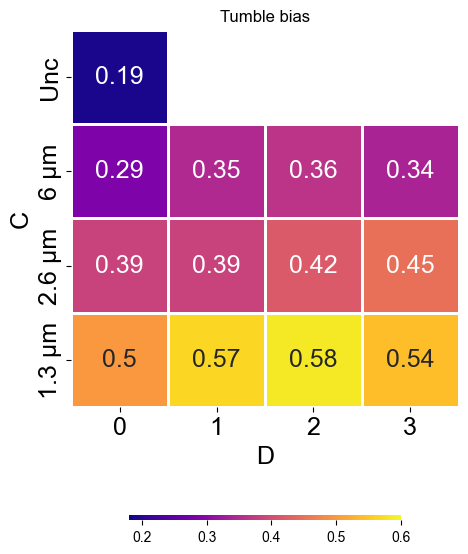

In [73]:
Tumbles = []
for condition, t in tumble_t_all.items():
    tumbles = []
    for bac in t:
        tumbles.append(len(bac))
    Tumbles.append(tumbles)

Runs = []
for condition, t in run_t_all.items():
    runs = []
    for bac in t:
        runs.append(len(bac))
    Runs.append(runs)
    
TB_all = []
for i,j in zip(Tumbles,Runs):
    TB = []
    for t,r in zip(i,j):
        tb = t / (t+r)
        TB.append(tb)
    TB_all.append(np.mean(TB))
    
TBs_all = TB_all + [np.nan] * 3

TBs = []
for i in TBs_all:
    i = round(i,3)
    TBs.append(i)

# Assign the tumble bias values to confinement and disorder
confinement = ['1.3 µm'] * 4 + ['2.6 µm'] * 4 + ['6 µm'] * 4 + ['Unc'] * 4
disorder = [0, 1, 2, 3] * 4

# Creating the DataFrame
df = pd.DataFrame({
    'C': confinement,
    'D': disorder,
    'TB': TBs
})

# Reorder the 'C' column to have rows from 'Unc' to '1.3 µm'
df['C'] = pd.Categorical(df['C'], categories=['Unc', '6 µm', '2.6 µm', '1.3 µm'], ordered=True)

# Pivot the DataFrame to structure it for a heatmap
htmp = df.pivot(index="C", columns="D", values="TB")

# Plotting the heatmap

mpl.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5, 7))
sns.heatmap(htmp, annot=True, vmin=0.18, vmax=0.6, cmap="plasma", cbar=True,linewidth=0.8,cbar_kws={
                "orientation": "horizontal",  # Place the colorbar on top
                "pad": 0.2,                   # Adjust the space between the heatmap and the colorbar
                "shrink": 0.7,                # Shrink the colorbar size
                "aspect": 50,                 # Adjust the aspect ratio of the colorbar
                "fraction": 0.1              # Fraction of the colorbar size relative to the plot
            },annot_kws={'size': 18})
plt.xlabel("D", fontsize=18)  # X-axis label size
plt.ylabel("C", fontsize=18)  # Y-axis label size
plt.title('Tumble bias')
plt.xticks(fontsize=18)  # X-axis tick label size
plt.yticks(fontsize=18)
plt.savefig('fig2e_htmp_tb.png', dpi=300,transparent=True)
plt.close()

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Unc'),
  Text(0, 1.5, '6 µm'),
  Text(0, 2.5, '2.6 µm'),
  Text(0, 3.5, '1.3 µm')])

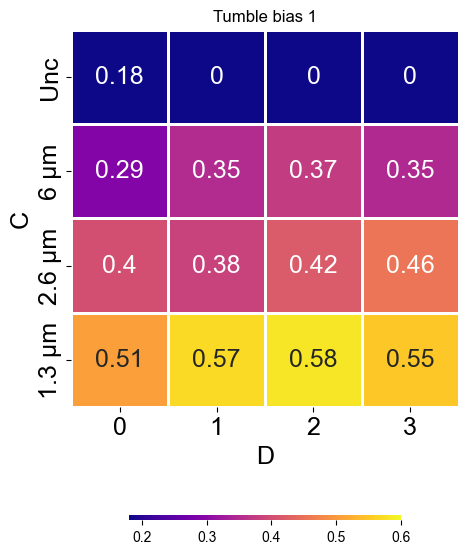

In [50]:
### compute run and tumble proportions 
number_run_states = []
for index, gp in df_run_t.groupby('Condition'):
    number_run_states.append(len(gp['Run T']))
    
number_tumble_states = []
for index, gp in df_tumble_t.groupby('Condition'):
    number_tumble_states.append(len(gp['Tumble T']))
    
## Calculate the probability of run states/tumble states
p_run_all = []
p_tumble_all = []
for i,j in zip(number_run_states,number_tumble_states):
    p_run = i/(i+j)
    p_tumble = j/(i+j)
    p_run_all.append(p_run)
    p_tumble_all.append(p_tumble)

p_t = p_tumble_all + [0.0] * 3

p_tum = []
for i in p_t:
    i = round(i,3)
    p_tum.append(i)

# Updated confinement and disorder values
confinement = ['1.3 µm'] * 4 + ['2.6 µm'] * 4 + ['6 µm'] * 4 + ['Unc'] * 4
disorder = [0, 1, 2, 3] * 4

# Creating the DataFrame
df = pd.DataFrame({
    'C': confinement,
    'D': disorder,
    'P_tum': p_tum
})

# Reorder the 'C' column to have rows from 'Unc' to '1.3 µm'
df['C'] = pd.Categorical(df['C'], categories=['Unc', '6 µm', '2.6 µm', '1.3 µm'], ordered=True)

# Pivot the DataFrame to structure it for a heatmap
htmp = df.pivot(index="C", columns="D", values="P_tum")

# Plotting the heatmap

mpl.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5, 7))
sns.heatmap(htmp, annot=True, vmin=0.18, vmax=0.6, cmap="plasma", cbar=True,linewidth=0.8,cbar_kws={
                "orientation": "horizontal",  # Place the colorbar on top
                "pad": 0.2,                   # Adjust the space between the heatmap and the colorbar
                "shrink": 0.7,                # Shrink the colorbar size
                "aspect": 50,                 # Adjust the aspect ratio of the colorbar
                "fraction": 0.1              # Fraction of the colorbar size relative to the plot
            },annot_kws={'size': 18})
plt.xlabel("D", fontsize=18)  # X-axis label size
plt.ylabel("C", fontsize=18)  # Y-axis label size
plt.title('Tumble bias 1')
plt.xticks(fontsize=18)  # X-axis tick label size
plt.yticks(fontsize=18)
#plt.savefig('fig2e_htmp_tumble.png', dpi=300,transparent=True)
#plt.show()
#plt.close()
    

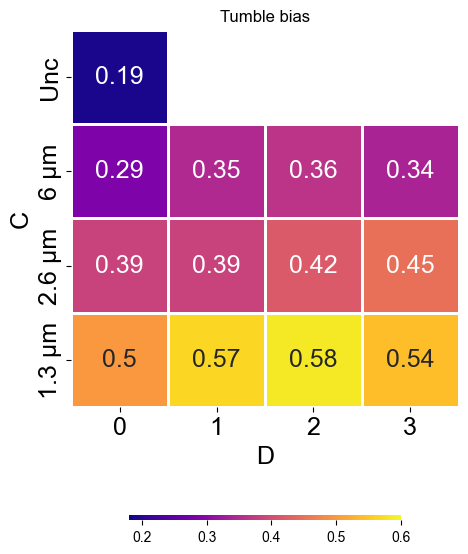

In [63]:
TBs_all = TB_all + [np.nan] * 3
TBs = []
for i in TBs_all:
    i = round(i,3)
    TBs.append(i)

# Updated confinement and disorder values
confinement = ['1.3 µm'] * 4 + ['2.6 µm'] * 4 + ['6 µm'] * 4 + ['Unc'] * 4
disorder = [0, 1, 2, 3] * 4

# Creating the DataFrame
df = pd.DataFrame({
    'C': confinement,
    'D': disorder,
    'P_tum': TBs
})

# Reorder the 'C' column to have rows from 'Unc' to '1.3 µm'
df['C'] = pd.Categorical(df['C'], categories=['Unc', '6 µm', '2.6 µm', '1.3 µm'], ordered=True)

# Pivot the DataFrame to structure it for a heatmap
htmp = df.pivot(index="C", columns="D", values="P_tum")

# Plotting the heatmap

mpl.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5, 7))
sns.heatmap(htmp, annot=True, vmin=0.18, vmax=0.6, cmap="plasma", cbar=True,linewidth=0.8,cbar_kws={
                "orientation": "horizontal",  # Place the colorbar on top
                "pad": 0.2,                   # Adjust the space between the heatmap and the colorbar
                "shrink": 0.7,                # Shrink the colorbar size
                "aspect": 50,                 # Adjust the aspect ratio of the colorbar
                "fraction": 0.1              # Fraction of the colorbar size relative to the plot
            },annot_kws={'size': 18})
plt.xlabel("D", fontsize=18)  # X-axis label size
plt.ylabel("C", fontsize=18)  # Y-axis label size
plt.title('Tumble bias')
plt.xticks(fontsize=18)  # X-axis tick label size
plt.yticks(fontsize=18)
plt.savefig('fig2e_htmp_tb.png', dpi=300,transparent=True)
plt.close()